In [ ]:
#importing important libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image as pic
import os
import numpy as np
import math
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import logging

Class Names =>  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


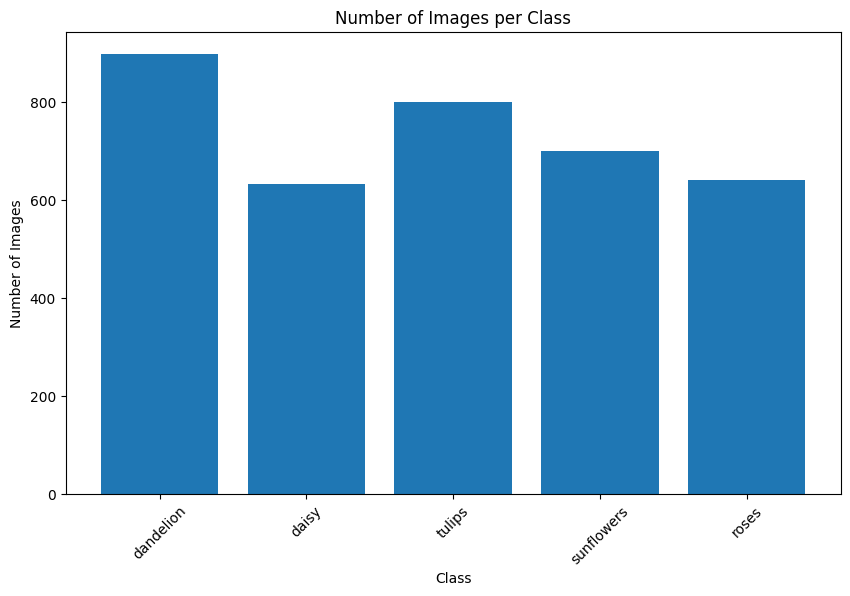

In [ ]:
# Setting logging level to error to avoid verbose output
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

dataset, metaset = tfds.load('tf_flowers', as_supervised=True, with_info=True)
train_data = dataset['train']

# Getting class names
class_names = metaset.features['label'].names
print("Class Names => ", class_names)

# Calculatingt the number of images per class
class_counts = {class_name: 0 for class_name in class_names}
for image, label in train_data:
    class_counts[class_names[label]] += 1

# Ploting the number of images per class
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Defining class names
class_names = metaset.features['label'].names
print("Class Names => ", class_names)

# Geting the number of training examples
num_train_examples = metaset.splits['train'].num_examples
print("Number of training examples: ", num_train_examples)

Class Names =>  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of training examples:  3670


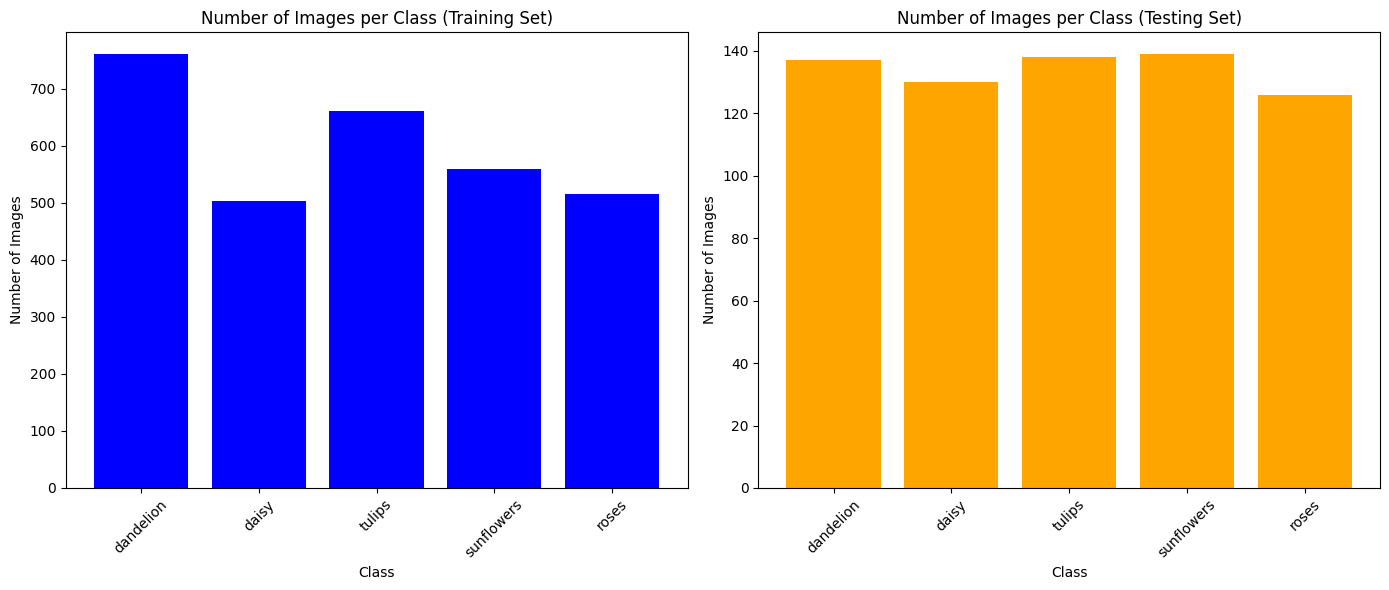

In [ ]:
# Splitting data into training and testing sets
train_size = 3000
test_size = 500

train_set = train_data.take(train_size)
test_set = train_data.skip(train_size)

# Defing batch size
batch_size = 32

# Calculating the number of images per class in the training set
train_class_counts = {class_name: 0 for class_name in class_names}
for image, label in train_set:
    train_class_counts[class_names[label]] += 1

# Calculating the number of images per class in the testing set
test_class_counts = {class_name: 0 for class_name in class_names}
for image, label in test_set:
    test_class_counts[class_names[label]] += 1

# Plot the number of images per class in both training and testing sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Training Set)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Testing Set)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

One Image from Training Set:


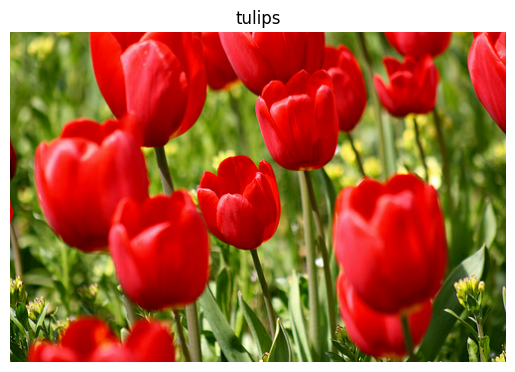

One Image from Testing Set:


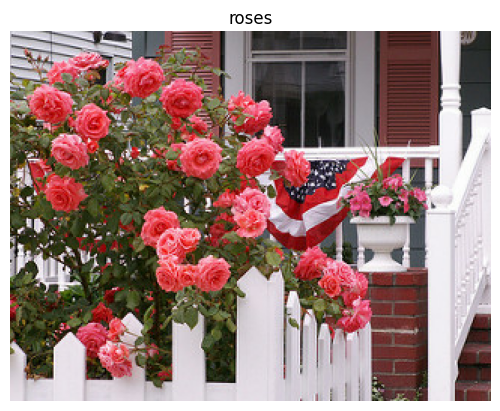

In [ ]:
#for displaying sample images
def display_image(dataset):
    for image, label in dataset.take(1):
        plt.imshow(image.numpy())
        plt.title(class_names[label.numpy()])
        plt.axis('off')
        plt.show()

# Displaying one image from the training set
print("One Image from Training Set:")
display_image(train_set)

# Displaying one image from the testing set
print("One Image from Testing Set:")
display_image(test_set)

In [ ]:
#function for normalizing and augmentation 
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Applying normalization to the dataset
train_set = train_set.map(preprocess)
train_set = train_set.cache()
# Applying normalization to the dataset
test_set = test_set.map(preprocess)
test_set = test_set.cache()

In [ ]:
# Creating batches of data for training and testing
train_set = train_set.cache().repeat().shuffle(train_size).batch(batch_size)
test_set = test_set.cache().batch(batch_size)


In [ ]:
# Defining the model with additional layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer for regularization
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add another dropout layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add another dropout layer
    tf.keras.layers.Dense(5)  # Output layer
])
model.summary();

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Displaing model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
# Training the model
history=model.fit(train_set, epochs=10, steps_per_epoch=math.ceil(train_size / batch_size))

# Evaluating the model on test data
test_accuracy = model.evaluate(test_set, steps=math.ceil(test_size / batch_size))
print("Test Accuracy => ", test_accuracy)

Epoch 1/10
94/94 [==============================] - 8s 61ms/step - loss: 1.5251 - accuracy: 0.3457
Epoch 2/10
94/94 [==============================] - 6s 62ms/step - loss: 1.2937 - accuracy: 0.4518
Epoch 3/10
94/94 [==============================] - 6s 60ms/step - loss: 1.1547 - accuracy: 0.5083
Epoch 4/10
94/94 [==============================] - 6s 62ms/step - loss: 0.9898 - accuracy: 0.6067
Epoch 5/10
94/94 [==============================] - 6s 60ms/step - loss: 0.8224 - accuracy: 0.6735
Epoch 6/10
94/94 [==============================] - 6s 65ms/step - loss: 0.6846 - accuracy: 0.7414
Epoch 7/10
94/94 [==============================] - 6s 61ms/step - loss: 0.4795 - accuracy: 0.8201
Epoch 8/10
94/94 [==============================] - 6s 63ms/step - loss: 0.3903 - accuracy: 0.8610
Epoch 9/10
94/94 [==============================] - 6s 62ms/step - loss: 0.2531 - accuracy: 0.9189
Epoch 10/10
16/16 [==============================] - 1s 55ms/step - loss: 1.6660 - accuracy: 0.6113
Test Accu

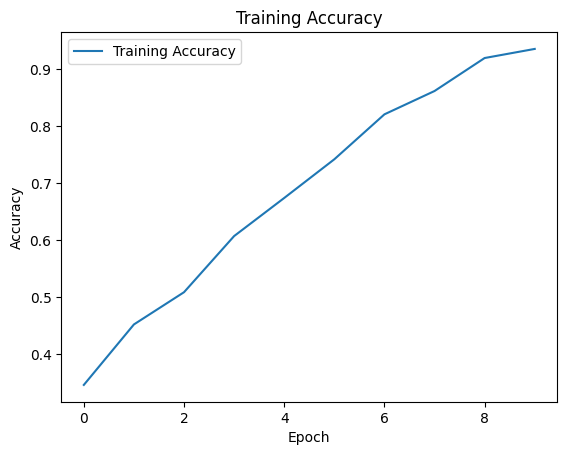

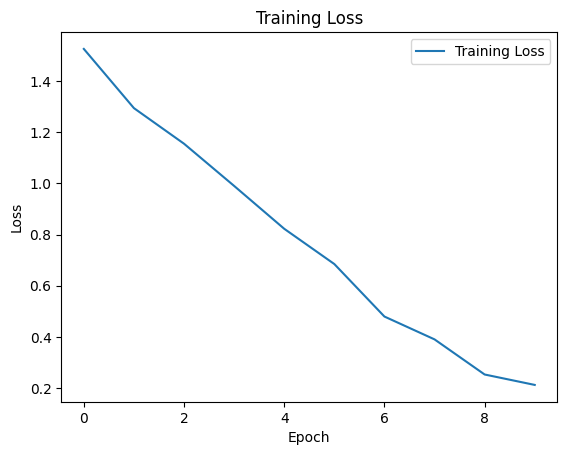

In [ ]:
# plotting accuracy
import matplotlib.pyplot as plt

# Plotting training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Plotting training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


16/16 [==============================] - 1s 72ms/step - loss: 1.6587 - accuracy: 0.6250
Epoch 1: Test Loss: 1.6587244272232056, Test Accuracy: 0.625
16/16 [==============================] - 1s 60ms/step - loss: 1.6865 - accuracy: 0.6074
Epoch 2: Test Loss: 1.686464548110962, Test Accuracy: 0.607421875
16/16 [==============================] - 1s 65ms/step - loss: 1.6485 - accuracy: 0.6191
Epoch 3: Test Loss: 1.6485008001327515, Test Accuracy: 0.619140625
16/16 [==============================] - 1s 58ms/step - loss: 1.6009 - accuracy: 0.6387
Epoch 4: Test Loss: 1.600886344909668, Test Accuracy: 0.638671875


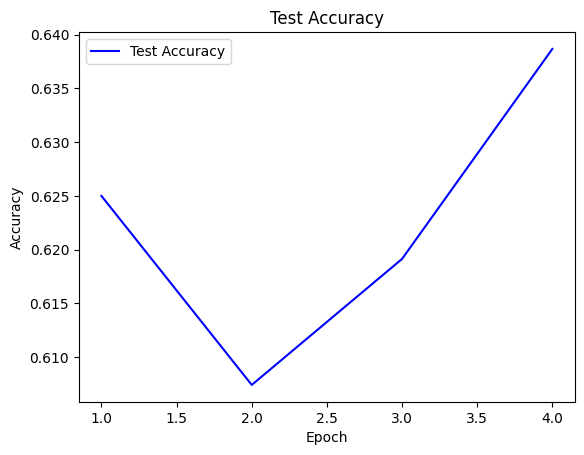

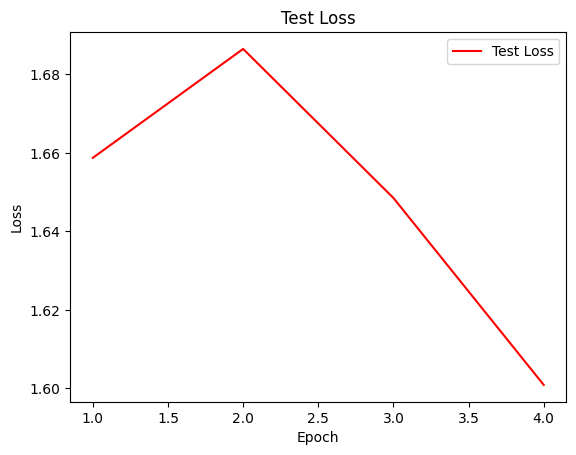

In [ ]:
# plotting testing accuracy
import matplotlib.pyplot as plt

# Initializing lists to store test accuracy and loss
test_accuracies = []
test_losses = []

# Loopping through epochs
for epoch in range(1, 5):  # Assuming you have trained for 5 epochs
    # Get test accuracy and loss from the evaluation
    test_loss, test_accuracy = model.evaluate(test_set, steps=math.ceil(test_size / batch_size))

    # Append test accuracy and loss to lists
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Print the obtained test loss and accuracy
    print(f"Epoch {epoch}: Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot test accuracy
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()

# Plot test loss
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


In [ ]:

# Predictting on a sample image from the web
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTTWaDvUHNQLhZId1rsACBXH6RDshpO5tV8Hg&usqp=CAU'
response = requests.get(image_url)
image = pic.open(BytesIO(response.content))
image_resized = image.resize((224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image_resized)
image_normalized = image_array / 255.0
image_for_model = tf.expand_dims(image_normalized, axis=0)

prediction = model.predict(image_for_model)
predicted_class_index = np.argmax(prediction)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
predicted_class = class_names[predicted_class_index]
print("Predicted Class => ", predicted_class)


1/1 [==============================] - 0s 360ms/step
Predicted Class =>  daisy


1/1 [==============================] - 0s 19ms/step


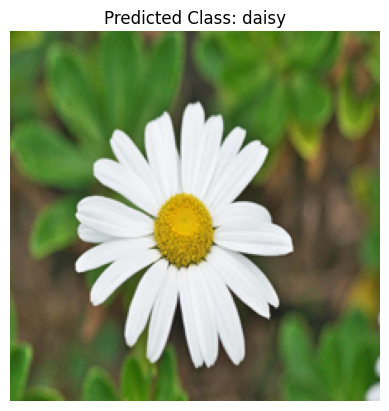

In [ ]:
import matplotlib.pyplot as plt


image_url = 'https://www.marthastewart.com/thmb/IGqKKyQ22a6-8nXmTOyDdXAa0xA=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/montauk-daisy-getty-1020-2000-8383fd0e293246679014c64c8ec427f3.jpg'
response = requests.get(image_url)
image = pic.open(BytesIO(response.content))
image_resized = image.resize((224, 224))

# Preprocess the image for model input
image_array = tf.keras.preprocessing.image.img_to_array(image_resized)
image_normalized = image_array / 255.0
image_for_model = tf.expand_dims(image_normalized, axis=0)

# Make prediction
prediction = model.predict(image_for_model)
predicted_class_index = np.argmax(prediction)
class_names =  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
predicted_class = class_names[predicted_class_index]

# Display the image with the predicted class
plt.imshow(image_resized)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 23ms/step


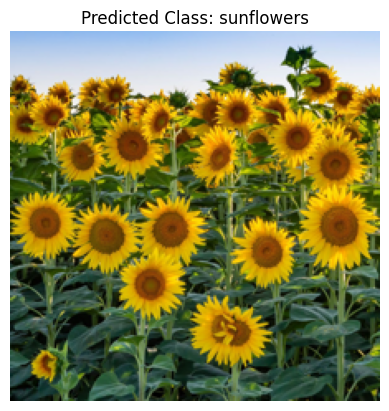

In [ ]:
import matplotlib.pyplot as plt


image_url = 'https://hips.hearstapps.com/hmg-prod/images/types-of-sunflowers-1646756873.jpg?crop=0.752xw:1.00xh;0.165xw,0&resize=1200:*'
response = requests.get(image_url)
image = pic.open(BytesIO(response.content))
image_resized = image.resize((224, 224))

# Preprocess the image for model input
image_array = tf.keras.preprocessing.image.img_to_array(image_resized)
image_normalized = image_array / 255.0
image_for_model = tf.expand_dims(image_normalized, axis=0)

# Make prediction
prediction = model.predict(image_for_model)
predicted_class_index = np.argmax(prediction)
class_names =  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
predicted_class = class_names[predicted_class_index]

# Display the image with the predicted class
plt.imshow(image_resized)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()